# LangGraph Demo
## 3 Agents 👇
* ReAct Agent built with LangGraph + Claude + Taviily Web Search + Wikipedia Search & Summarization
* Agentic Workflow that has access to the same

In [1]:
#import environment file
import os
from dotenv import load_dotenv

# Load the .env file
load_dotenv()

# text structure
from typing import Annotated
from typing_extensions import TypedDict
from typing import List, Union, Callable
from pydantic import BaseModel, Field
from urllib.parse import quote

# datetime
from datetime import datetime, timezone
import time
import uuid

# LangGraph graph def
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import SystemMessage

# Messages
from langchain_core.messages import AIMessage, HumanMessage

# Claude & OpenAI integration
from langchain_anthropic import ChatAnthropic
from langchain_openai import ChatOpenAI

# creating ReAct agents with Supervisor architecture
from langgraph_supervisor import create_supervisor
from langgraph.prebuilt import create_react_agent

# memory
from langgraph.checkpoint.memory import MemorySaver

# Define Tavily Search + Wiki Tools
from langchain_core.tools import Tool
from langchain.tools import tool
from langchain_community.tools.tavily_search.tool import TavilySearchResults
from langchain_community.utilities import WikipediaAPIWrapper

# pandas
import pandas as pd

# jupyter finessing
from IPython.display import Image, display, Markdown
import warnings
warnings.filterwarnings('ignore')

# gradio
import gradio as gr

# needed for concurrent evals in notebook envs
import nest_asyncio
nest_asyncio.apply() 

# ReAct Agent

## Model Initialization 🎈

In [2]:
anthropic_api_key = os.getenv("ANTHROPIC_API_KEY")
if not anthropic_api_key:
    print("ANTHROPIC_API_KEY environment variable not set.")

In [3]:
MODEL = 'claude-sonnet-4-20250514'
# 'claude-4-sonnet-20250514'
# 'claude-opus-4-20250514'

In [4]:
claude = ChatAnthropic(
    model_name=MODEL,
    temperature=1,
    max_tokens=2000,
    
    # Enable thinking with budget_tokens as required by API  
    thinking={"type": "enabled", "budget_tokens": 1024},
    
    # Enable interleaved thinking for better tool use and reasoning
    extra_headers={
        "anthropic-beta": "interleaved-thinking-2025-05-14"
    },
    
    # Enable keep-alive as recommended by Anthropic
    timeout=300.0,  # 5 minute timeout
)

## Define Tools ⚙️

### 1️⃣ Tavily Search

In [5]:
tavily_api_key = os.getenv("TAVILY_API_KEY")
if not tavily_api_key:
    print("TAVILY_API_KEY environment variable not set.")

In [6]:
def create_tavily_search_tool(tavily_api_key):
    """
    Create the Tavily search tool with token management.
    
    Args:
        tavily_api_key: API key for Tavily
    Returns:
        Configured search tool or None if failed

     Use this tool when:
    - User asks questions that require current info
    """
    try:
        def tavily_search(query, *args, **kwargs):
            
            try:
                print(f"Making Tavily API call for: {query[:50]}...")
                results = TavilySearchResults(api_key=tavily_api_key,
                                             # k=1,
                                             include_raw_content=False,
                                             include_images=False,
                                             include_answer=True,
                                             max_results=1,
                                             search_depth="basic")(query, *args, **kwargs)
                
                return results
                
            except Exception as e:
                print(f"Error in Tavily search: {e}")
                
                return error_result

        search_tool = Tool(
            name="tavily_search_results",
            func=tavily_search,
            description=
            "Search the web for current information. Useful for questions about current events or trending topics."
        )

        print("Successfully initialized Tavily Search with token management")
        return search_tool

    except Exception as e:
        print(f"Failed to initialize Tavily Search: {e}")
        return None

### 2️⃣ DateTime Tool

In [7]:
@tool
def get_current_datetime() -> str:
    """
    Get the current date and time in a user-friendly format.
    
    Returns:
        str: Current date and time in format "Friday, May 23, 2025 at 12:45 PM EST"
    
    Use this tool when:
    - User asks about current date, time, or "today"
    - User mentions "this week", "next week", "this month", etc.
    - User asks about weather forecasts or current events
    - Any time-sensitive queries that need current context
    """
    try:
        # Get current datetime in UTC
        now_utc = datetime.now(timezone.utc)
        
        # Format for user display
        formatted_date = now_utc.strftime("%A, %B %d, %Y at %I:%M %p UTC")
        
        return f"Current date and time: {formatted_date}"
        
    except Exception as e:
        error_msg = f"Error getting current datetime: {str(e)}"
        print(error_msg)
        return error_msg

### 3️⃣ Wiki Tool

In [8]:
def create_wikipedia_tool():
    """
    Create a Wikipedia search tool.

    Returns:
        Configured Wikipedia tool or None if failed
    """
    try:
        api_wrapper = WikipediaAPIWrapper(top_k_results=3, doc_content_chars_max=3000)

        # Wrap the Wikipedia run to provide error handling, token management, and caching
        def wiki_query_with_handling(query):
            # Input validation
            if not query or not isinstance(query, str):
                return "Invalid query: Please provide a valid search term."
            
            # Sanitize query - remove potentially problematic characters
            query = query.strip()
            if len(query) > 300:  # Align with WIKIPEDIA_MAX_QUERY_LENGTH
                query = query[:300]
            
            try:
                print(f"Making Wikipedia API call for: {query[:50]}...")
                result = api_wrapper.run(query)

                # Limit result size to avoid token issues
                if len(result) > 4000:
                    result = result[:4000] + "... [content truncated for brevity]"

                # Add Wikipedia source URL with proper encoding
                wiki_title = quote(query.replace(' ', '_'), safe='')
                wiki_url = f"https://en.wikipedia.org/wiki/{wiki_title}"
                result += f"\n\nSources:\n{wiki_url}"

                return result
                
            except Exception as e:
                error_result = "Wikipedia search encountered an error. Please try a different query or check your connection."
                print(f"Error in Wikipedia search: {e}")
                
                return error_result

        # Create the tool with our wrapped function
        wiki_tool = Tool(
            name="wikipedia_query_run",
            func=wiki_query_with_handling,
            description="""Searches Wikipedia for information about a given topic. 
            Use for historical, scientific, or general knowledge queries.
            """
        )

        print("Successfully initialized Wikipedia tool")
        return wiki_tool

    except Exception as e:
        print(f"Failed to initialize Wikipedia tool: {e}")
        return None

### Prompt Template 📝

In [9]:
def get_prompt():
    """
    Returns an enhanced prompt for the ReACT agent that coordinates between multiple tools.
    Include special instructions for handling content.
    """
    return """
    You are an expert AI assistant with access to powerful tools for research and information gathering.

    CAPABILITIES:
    - Web search via Tavily (for current events, news, real-time information)
    - Wikipedia search (for encyclopedic knowledge, historical facts, established concepts)
    - Current date/time information
    
    INSTRUCTIONS:
    1. **Tool Selection Strategy**:
       - Use Tavily search for: recent events, current facts, market data, news, trending topics
       - Use Wikipedia for: historical information, established concepts, biographical data, scientific facts
       - Get current datetime before searching when queries involve time-sensitive information
    
    2. **Response Guidelines**:
       - Always provide direct, helpful answers based on your research
       - Synthesize information from multiple sources when appropriate
       - If you need to search for information, explain briefly what you're looking for
       - Cite sources when presenting factual claims from your searches
       - Be concise but thorough in your explanations
    
    3. **Search Strategy**:
       - For time-sensitive queries (weather, recent events), always get current date first
       - Use multiple searches if needed to provide comprehensive answers
       - Prefer authoritative sources and recent information
    
    4. **Communication Style**:
       - Be helpful, accurate, and conversational
       - Acknowledge when you're searching for information
       - Present information clearly and organize complex topics logically
    
    Current date context will be provided when you use the datetime tool.
    """

## Initialize Tools ✅ 

In [10]:
# 2. Initialize the tools properly by calling the factory functions
def initialize_tools():
    """Initialize all tools and return them as a list"""
    tools = []
    
    # Initialize Tavily search tool
    if tavily_api_key:
        tavily_tool = create_tavily_search_tool(tavily_api_key)
        if tavily_tool:
            tools.append(tavily_tool)
            print("✅ Tavily search tool initialized")
        else:
            print("❌ Failed to initialize Tavily search tool")
    else:
        print("⚠️ Tavily API key not found, skipping Tavily tool")
    
    # Initialize Wikipedia tool
    wiki_tool = create_wikipedia_tool()
    if wiki_tool:
        tools.append(wiki_tool)
        print("✅ Wikipedia tool initialized")
    else:
        print("❌ Failed to initialize Wikipedia tool")
    
    # Add datetime tool
    tools.append(get_current_datetime)
    print("✅ DateTime tool initialized")
    
    return tools

# 3. Initialize tools
available_tools = initialize_tools()

print(f"\n🎯 Agent created with {len(available_tools)} tools:")
for tool in available_tools:
    if hasattr(tool, 'name'):
        print(f"   - {tool.name}")
    else:
        print(f"   - {tool}")

Successfully initialized Tavily Search with token management
✅ Tavily search tool initialized
Successfully initialized Wikipedia tool
✅ Wikipedia tool initialized
✅ DateTime tool initialized

🎯 Agent created with 3 tools:
   - tavily_search_results
   - wikipedia_query_run
   - get_current_datetime


## Create First ReAct Agent 🤖

In [11]:
agent_one = create_react_agent(
    model=claude,
    tools=available_tools,
    name="expert_sme",
    prompt=get_prompt(),

    # add Memory
    checkpointer=MemorySaver()
)

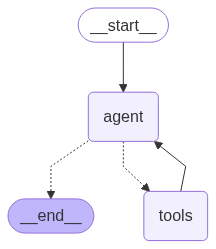

In [12]:
display(Image(agent_one.get_graph().draw_mermaid_png()))

## ❓Questions with Multiple Tool Runs

In [13]:
def user_agent_trace(query):
    """
    Break down user / agent interaction trace into streams for surface-level observability.
    """
    _thread_counter = 0
    
    # Get tracer (ensure Phoenix is set up first)
    # tracer = trace.get_tracer(__name__)
    
    # Auto-increment thread_id
    _thread_counter += 1
    thread_id = f"thread_{datetime.now().strftime('%Y%m%d_%H%M%S')}_{_thread_counter}"

    # Define config with thread_id
    config = {
        "configurable": {
            "thread_id": thread_id
        },
        "recursion_limit": 50,
        "max_execution_time": 300,  # 5 min timeout
    }
    
    print(f"\n🤔 USER QUERY: {query}")
    print(f"🔗 Thread ID: {thread_id}")
    print("=" * 80)
    
    step_counter = 1
    reasoning_parts = []
    
    for msg, metadata in agent_one.stream(
        {"messages": [HumanMessage(content=query)]}, 
        config, 
        stream_mode="messages"
    ):
        # safely extract message type
        msg_type = getattr(msg, 'type', None) 
        
        # Handle HumanMessage (user input)
        if isinstance(msg, HumanMessage):
            continue  # Skip user messages in trace
        
        # Handle AIMessage (assistant responses)
        elif hasattr(msg, 'content') and msg.content:
            
            if isinstance(msg.content, list):
                for block in msg.content:
                    if isinstance(block, dict):
                        block_type = block.get('type', '')
                        
                        # Reasoning/Thinking
                        if block_type == 'thinking':
                            reasoning_parts.append(block.get('thinking', ''))
                        
                        # Agent speech/explanation
                        elif block_type == 'text':
                            # Show accumulated reasoning first
                            if reasoning_parts:
                                reasoning_text = ''.join(reasoning_parts).strip()
                                if reasoning_text:
                                    print(f"\n🧠 STEP {step_counter} - AGENT REASONING:")
                                    print(f"   {reasoning_text}")
                                    reasoning_parts = []
                                    step_counter += 1
                            
                            text_content = block.get('text', '').strip()
                            if text_content:
                                print(f"\n🤖 ASSISTANT RESPONSE:")
                                print(f"   {text_content}")
                        
                        # Tool usage
                        elif block_type == 'tool_use':
                            tool_name = block.get('name', '')
                            tool_input = block.get('input', {})
                            
                            print(f"\n🔧 TOOL CALL:")
                            print(f"   Using: {tool_name}")
                            if tool_input:
                                print(f"   Parameters: {tool_input}")
            
            # Handle direct string responses
            elif isinstance(msg.content, str):
                content = msg.content.strip()
                if content:
                    print(f"\n🤖 ASSISTANT:")
                    print(f"   {content}")
        
        # Handle ToolMessage (tool results)
        elif msg_type == 'tool':
            print(f"\n📊 TOOL RESULT:")
            content = getattr(msg, 'content', '')
            # Truncate long tool results for readability
            if len(content) > 300:
                print(f"   {content[:300]}...")
            else:
                print(f"   {content}")
    
    # Show any final reasoning
    if reasoning_parts:
        reasoning_text = ''.join(reasoning_parts).strip()
        if reasoning_text:
            print(f"\n🧠 FINAL REASONING:")
            print(f"   {reasoning_text}")
    
    print(f"\n✅ QUERY COMPLETED")
    print("=" * 80)

In [14]:
queries = [
    "what's the weather like in Queens today?", 
    "Who was the King of the Ancient Greek Gods?",
    "What's the best method to evaluate an LLM?"
]

In [15]:
print("=" * 80)
user_agent_trace(queries[0])


🤔 USER QUERY: what's the weather like in Queens today?
🔗 Thread ID: thread_20250910_210516_1

🧠 STEP 1 - AGENT REASONING:
   The user is asking about today's weather in Queens. This is a time-sensitive query that requires current information, so I should:

1. First get the current date/time to know what "today" refers to
2. Then search for current weather information in Queens using Tavily search

Let me start with getting the current datetime.

🤖 ASSISTANT RESPONSE:
   I'll help you find the current weather in Queens.

🤖 ASSISTANT RESPONSE:
   Let me first get today's date and then

🤖 ASSISTANT RESPONSE:
   search for the latest weather information.

🔧 TOOL CALL:
   Using: get_current_datetime

🤖 ASSISTANT:
   Current date and time: Thursday, September 11, 2025 at 01:05 AM UTC

🔧 TOOL CALL:
   Using: tavily_search_results
Making Tavily API call for: current weather Queens New York today September 11...

🤖 ASSISTANT:
   [{"title": "Weather in Queens, New York", "url": "https://www.wea

# Workflow Demo

In [16]:
# Create a ToolNode to handle LangChain tool calls
tool_node = ToolNode(available_tools)

# Bind the custom LangChain tools to the LLM
model_with_tools = claude.bind_tools(available_tools)

# # Define workflow functions

# ## Create a stopping function
# Use MessagesState to define the state of the stopping function
def should_continue(state: MessagesState) -> str:
    """
    Determines whether the agent should continue processing or end.
    Args:
        state: The current state of the graph, containing messages.
    Returns:
        "tools" if the last message contains tool calls, END otherwise.
    """
    # Get the last message from the state
    last_message = state["messages"][-1]

    # Check if the last message is an AIMessage and has tool_calls
    # LangChain tools bound with .bind_tools() appear in `tool_calls`
    # Adjust this logic if necessary based on how built-in tool calls are represented.
    if isinstance(last_message, AIMessage) and hasattr(last_message, 'tool_calls') and last_message.tool_calls:
         # Check specifically for LangChain tool calls
        if any(tc.get('name') in [t.name for t in available_tools] for tc in last_message.tool_calls):
             return "tools" # Route to the LangChain tool node

    # Check for Google built-in tool calls (heuristic, might need adjustment)
    if isinstance(last_message, AIMessage) and last_message.additional_kwargs.get("tool_calls"):
         # The model might handle these directly without needing an explicit "tools" step in the graph
         # If the model *responds* with content after using a built-in tool, we might want to end.
         # If it needs explicit execution confirmation/results, the graph needs adjustment.
         # For now, assume the model handles built-in tools and we end if no *LangChain* tools are called.
         pass # Let the flow continue to END if no LangChain tools were called

    # End the conversation if no explicit LangChain tool calls are present
    return END


## Create the system prompt 
def create_agent_prompt():
    """
    Creates a comprehensive prompt template for the workflow agent.
    """
    system_template = get_prompt()

    # Create the full prompt template
    prompt = ChatPromptTemplate.from_messages([
        ("system", system_template),
        MessagesPlaceholder(variable_name="messages")
    ])
    
    return prompt


def call_model_with_prompt(state: MessagesState) -> dict:
    """
    Enhanced agent node function that uses a prompt template.
    Args:
        state: The current state of the graph.
    Returns:
        A dictionary containing the updated messages list.
    """
    messages = state["messages"]
    
    # Get the prompt template
    prompt_template = create_agent_prompt()
    
    # Format the prompt with current messages
    # This creates a properly formatted conversation with system instructions
    formatted_messages = prompt_template.format_messages(messages=messages)
    
    # Invoke the model with the formatted prompt
    response = model_with_tools.invoke(formatted_messages)
    
    return {"messages": [response]}

    
## Create a dynamic tool caller (Agent Node)
def call_model(state: MessagesState) -> dict:
    """
    The main agent node function. Invokes the LLM.
    Args:
        state: The current state of the graph.
    Returns:
        A dictionary containing the updated messages list.
    """
    # Note: The original function had logic to handle tool responses directly.
    # In a typical LangGraph setup, the ToolNode handles executing tools
    # and adding ToolMessages back to the state. This node should primarily
    # focus on calling the LLM with the current state.

    messages = state["messages"]
    response = model_with_tools.invoke(messages)
    # The response from the LLM (which might include content and/or tool calls)
    # is added back to the state.
    return {"messages": [response]}

In [17]:
# # Create the graph
workflow = StateGraph(MessagesState)

# Add nodes for chatbot (agent) and LangChain tools
workflow.add_node("chatbot", call_model)
workflow.add_node("tools", tool_node) # Node to execute LangChain tools

# Connect the START node to the chatbot
workflow.set_entry_point("chatbot")

# Define conditional edges:
# After chatbot node, check if we should continue (call tools) or end.
workflow.add_conditional_edges(
    "chatbot",
    should_continue,
    {
        "tools": "tools", # If should_continue returns "tools", go to the tools node
        END: END          # If should_continue returns END, finish the graph
    }
)

# After the tools node executes tools, always go back to the chatbot node
# The ToolNode adds ToolMessages, and the chatbot node will process them.
workflow.add_edge("tools", "chatbot")

# Adding memory
# Set up memory and compile the workflow
memory = MemorySaver()
app = workflow.compile(checkpointer=memory)

In [18]:
# # Organize chatbot outputs with memory
# ## Streaming outputs with memory (Alternative Streaming Approach)

# Set up a streaming function for a single user session
def stream_memory_responses(user_input: str, thread_id: str):
    """
    Streams all events from the graph execution for a single input.
    Args:
        user_input: The user's input string.
        thread_id: The unique identifier for the conversation thread.
    """
    config = {"configurable": {"thread_id": thread_id}}
    print(f"\n--- Streaming Events (Thread: {thread_id}, Input: '{user_input}') ---")

    # Stream the events in the graph
    for event in app.stream({"messages": [("user", user_input)]}, config):

        # Return the agent's last response
        for value in event.values():
            if "messages" in value and value["messages"]:
                print("Agent:", value["messages"])

In [19]:
print("Starting Agentic LangGraph Script...")

# --- Example 3: Streaming all graph events ---
thread3_id = "thread-example-3-stream"
stream_memory_responses("What is the Parthenon?", thread3_id)

print("\nScript finished.")

Starting Agentic LangGraph Script...

--- Streaming Events (Thread: thread-example-3-stream, Input: 'What is the Parthenon?') ---
Agent: [AIMessage(content=[{'signature': 'EsEDCkYIBxgCKkAPlXsFQ0EhSSovLbj3skYinR9GzvXglom3o0C/proH27ow+sQInffFmSUiOQzSwENCLNLk0egOwKsQIpXBwEhjEgx9m+2eV3YLKq1Cq/kaDAdisRSHUGVW4mkXriIw986reGXTQQsMJbkFUdH1yqRiBUxIX+eA9l2Uu/72Brt9hOS4gvHgat/4uGH60O13KqgC7suaPQ2+qkRSQx2Qhi/dWOzCxKV9OJ4HJzzd3/0HgqyvbZIXcsMOxpcllMWabNbir5A04Nz8s5XKy7IP4vG9vCxi3vIYGeTjW8WLoBhrSU41yHyDfb2v6DZ91ZrRIIG4y6wAHlHlJvo+J0l20W+zRQ0JkfFIZmXDpDZ7aA9S1vVaLJrP0BpUaJqCp6JBlSMOOee7Px3+YKzZY9AHyq7BFvm+w3dc4ZBzLm4n6uIOu63Dt5r3Y03K9SlZkRDwIi3dwLgaZG/80q3jcA20heob/ie/y5LaEzhwUrqn8vGHtGQoq3iwWdrdJ3damrzbbTjSP2+1MfWSL/urgc2hGyLJrYfDkKEcyB0Ck0r7Mymeh9VMj3b4R3blFVfNQhTKU9TnN+m3G6zEh9kYAQ==', 'thinking': "The user is asking about the Parthenon. This is a well-known historical and architectural structure. I should use the Wikipedia query function to get detailed, accurate information about the Parthenon sin

In [ ]:
# Interactive Chat Loop for Jupyter Notebook

print("Starting Agentic LangGraph Script...")
print("🤖 Interactive Chat Session")
print("=" * 50)
print("Commands:")
print("- Type your message to chat with the agent")
print("- Type 'quit', 'exit', or 'bye' to end the session")
print("- Type 'clear' to start a new conversation thread")
print("- Type 'help' to see these commands again")
print("=" * 50)

# Initialize thread ID
thread_id = f"interactive-thread-{str(uuid.uuid4())[:8]}"
message_count = 0

# Main chat loop
while True:
    try:
        # Get user input
        user_input = input(f"\n[Message {message_count + 1}] You: ").strip()
        
        # Handle empty input
        if not user_input:
            print("Please enter a message or 'quit' to exit.")
            continue
        
        # Handle exit commands
        if user_input.lower() in ['quit', 'exit', 'bye', 'q']:
            print("\n👋 Ending chat session. Goodbye!")
            break
        
        # Handle clear command
        elif user_input.lower() == 'clear':
            thread_id = f"interactive-thread-{str(uuid.uuid4())[:8]}"
            message_count = 0
            print(f"🔄 Started new conversation thread: {thread_id}")
            continue
        
        # Handle help command
        elif user_input.lower() == 'help':
            print("\nCommands:")
            print("- Type your message to chat with the agent")
            print("- Type 'quit', 'exit', or 'bye' to end the session")
            print("- Type 'clear' to start a new conversation thread")
            print("- Type 'help' to see these commands again")
            continue
        
        # Process the user input with the agent
        print(f"\n🔄 Processing... (Thread: {thread_id})")
        stream_memory_responses(user_input, thread_id)
        message_count += 1
        
    except KeyboardInterrupt:
        print("\n\n⚠️ Chat session interrupted by user (Ctrl+C)")
        break
    except EOFError:
        print("\n\n⚠️ Input stream ended")
        break
    except Exception as e:
        print(f"\n❌ Error occurred: {e}")
        print("Continuing chat session...")

print(f"\nScript finished. Total messages processed: {message_count}")

# Optional: Display conversation statistics
print(f"\n📊 Session Summary:")
print(f"   - Thread ID: {thread_id}")
print(f"   - Messages processed: {message_count}")
print(f"   - Session ended gracefully")

Starting Agentic LangGraph Script...
🤖 Interactive Chat Session
Commands:
- Type your message to chat with the agent
- Type 'quit', 'exit', or 'bye' to end the session
- Type 'clear' to start a new conversation thread
- Type 'help' to see these commands again
